<a href="https://colab.research.google.com/github/euphoria96/KB_Smishing_dacon/blob/master/Model8_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting
### Mounting google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

### Download Mecab

In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/smishing/Mecab-ko-for-Google-Colab

/content/gdrive/My Drive/Colab Notebooks/smishing/Mecab-ko-for-Google-Colab


In [0]:
! bash install_mecab-ko_on_colab190912.sh

### Import packages

In [0]:
# data preprocessing
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
# tokenizer
import re
from konlpy.tag import Mecab
# modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Bidirectional, Flatten, Input, SpatialDropout1D, Conv1D, MaxPooling1D, GRU, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
import pickle
import time
import warnings
warnings.filterwarnings(action='ignore') 

### Load Data

In [5]:
path = '/content/gdrive/My Drive/Colab Notebooks/smishing/'
train = pd.read_csv(path+'data/train.csv')
test = pd.read_csv(path+'data/public_test.csv')
submission=pd.read_csv(path+'data/submission_제출양식.csv')
print(train.shape, test.shape, submission.shape)
train.head()

(295945, 4) (1626, 3) (1626, 2)


,id,year_month,text,smishing
0,0,2017-01,XXX은행성산XXX팀장입니다.행복한주말되세요,0
1,1,2017-01,오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림,0
2,2,2017-01,안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니...,0
3,4,2017-01,XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 ...,0
4,5,2017-01,1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다,0


## Data Preparation
### Sampling
- Ensemble different resampled dataset
- 0    277242, 1     18703

In [0]:
## for train data
RANDOM_SEED = 1234
# index
train_nsm_idx=list(train[train['smishing']==0].index)
train_sm_idx=list(train[train['smishing']==1].index)
## for test data
test['smishing'] = 2
test_X = pd.DataFrame(test['text'])
test_y = pd.DataFrame(test['smishing'])
print(test_X.shape, test_y.shape)

In [0]:
def data_resampling(train, i):
  train_nsm_idx_smp = train_nsm_idx[i*18703:(i+1)*18703] # split index
  train_idx = train_nsm_idx_smp + train_sm_idx # merge index
  print('original  idx: ',train_idx[:5])
  random.shuffle(train_idx) # index shuffle
  print('resampled idx: ',train_idx[:5])
  train_X = pd.DataFrame(train['text'], columns=['text']).iloc[train_idx].reset_index(drop=True)
  train_y = pd.DataFrame(train['smishing'], columns=['smishing']).iloc[train_idx].reset_index(drop=True)
  print(train_X.shape, train_y.shape)
  return train_X, train_y

In [0]:
def data_preparation(train, test, i):
  train_X, train_y = data_resampling(train, i)
  print(pd.DataFrame([len(x) for x in train_X.text]).describe().transpose())
  

In [30]:
train_X, train_y = data_resampling(train, 0)

[0, 1, 2, 3, 4]
[7601, 6758, 17591, 149335, 216976]
(37406, 1) (37406, 1)


### Tokenizing

In [32]:
tmp = [len(x) for x in train_X.text]
print(pd.DataFrame(tmp).describe().transpose())

     count        mean         std   min   25%    50%    75%     max
0  37406.0  475.304844  371.984006  14.0  87.0  417.0  877.0  1259.0


In [0]:
stopwords = ['을', '를', '이', '가', '은', '는', 'null']
'''stoptags = ['J','E']
repl_dict = {'포토 폴리오':'포트폴리오','포토 폴 리어':'포트폴리오','햇살 론':'햇살론','새 희망 홀씨':'새희망홀씨','고객 님':'고객님','null':'', '할부금융':'할부 금융','이 체':'이체',
             '자동 화 기기':'자동화기기','문 의':'문의','심의 필':'심의필','주 거래':'주거래','일시 불':'일시불','균 등':'균등','대 출한 도':'대출 한도','카드 론':'카드론', '선수 수료':'선 수수료','준 법':'준법','연소 득':'연 소득'}'''
def tokenizing(text_list):
  tokenizer = Mecab()
  token_list = []
  for text in text_list:
    txt = text.lower().replace('c i t i','citi').replace('k o r e a','korea')
    txt = re.sub('[^가-힣a-z]',' ',txt)
    txt = re.sub('x{1,}',' ',txt)
    '''token = tokenizer.pos(txt)
    tokens = [t[0] for t in token if t[1][0] not in stoptags and (t[0].isalpha()*len(t[0])>1)] # 조사,어미,길이1 뺌
    txt_ = ' '.join(tokens)
    for r in repl_dict.items():
      txt_ = re.sub(r[0],r[1],txt_)
    token_list.append(txt_)'''
    token = tokenizer.morphs(txt)
    tokens = [t for t in token if t not in stopwords]
    token_list.append(' '.join(tokens))
  return token_list

In [0]:
train_X_txt = tokenizing(train_X.text)
test_X_txt = tokenizing(test_X.text)

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X_txt)  
train_X_seq = tokenizer.texts_to_sequences(train_X_txt) 
vocab_size = len(tokenizer.word_index) + 1
print('vocab size: ', vocab_size)
max_len = 1000 
X_train = pad_sequences(train_X_seq, maxlen=max_len)
print("train data shape: ", X_train.shape)
test_X_seq = tokenizer.texts_to_sequences(test_X_txt) 
X_test = pad_sequences(test_X_seq, maxlen=max_len)
print("test data shape: ", X_test.shape)

vocab size:  22611
train data shape:  (112218, 1000)
test data shape:  (1626, 1000)


In [0]:
for i in sm_idx[:5]:
  print(train_X_txt[i])

광고 바빌론 상품 안내 년 와 함께 안녕 하 세요 저희 에서 신규 상품 출시 되 여 채무 통합 대환 상품 신규 상품 가능 고객 으로 선정 되 어 안내 차 연락 드립니다 여유 시간 내 어 읽 어 주 신다면 도움 되 실 거 라 생각 되 어 안내장 보내 드립니다 금리 최저 저렴 한 금리 기준 금리 산 금리 한 도최 대 억 천만 원 대환 자금 추가 자금 조건 사업자 직장 인 프리랜서 무직자 주부 상담 상품 의 특징 가상 조회 로 한도 금리 한 번 에 알 수 있 슴 은행 사금융 등 낮 금리 로 대환 할 수 있 슴 꼭 주 거래 은행 아니 라도 관계없이 진행 가능 담보 최저 금리 최 대 한도 장기 모기지 일반 담보 대출 상담 가능 채무 통합 상품 원리금 균 등 원금 자 방식 이자 만 내 방식 으로 전환 연소 득 대비 이내 과다 채무자 통합 가능 카드 론 현금 서비스 과다 이용 잦 고객 채무 금액 작 으나 건수 여러 건 으로 이용 중 인 고객 채무 통합 의 핵심 포인트 월 납입금 액 감소 및 자금액 최대 감소 시켜 드립니다 신용도 상향 등급 으로 상승 시켜 드립니다 퍼져 있 부채 건 으로 줄여 관리 하 기 편하 게 만들 어 드립니다 추가 자금 필요 할 때 은행 권 으로 가능 하 실 수 있 게 해 드립니다 신청 방법 상담 가능 시간 성함 문자 예약 또는 전화 주 시 면 상담 가능 간단 한 문 의 사항 라도 성실 한 답변 해 드리 겠 습니다 전화 상담 카톡 상담 가능 id sb 해당 되 지 않 으시 거나 거부 원하 시 분 들 거부 라고 회신 하 여 주 신다면 재 발송 않 도록 하 겠 습니다 문자 불편 하 셨 다면 죄송 합니다 무료 수신 거부 광고 바빌론 신규 상품
광고 상담 고객 입니다 항상 이용 해 주 셔서 감사 합니다 내용 무담보 신상품 출시 안 내본 상품 서민 지원 대출 로 정부 에서 지원 하 고 은행 에서 판매 하 대 입니다 상품 특징 무담보 무 보증 무 수수료 신용 등급 상관없이 최고 한도 억 최하 금리 상환 수수료 없이 자유 롭 게 상환 가능 기존 대출 저금리 전환 

In [0]:
for i in sm_idx[:5]:
  print(train_X_txt[i])

광고 바빌론 상품 안내 함께 안녕 저희 신규 상품 출시 채무 통합 대환 상품 신규 상품 가능 고객 선정 안내 연락 드립니다 여유 시간 도움 생각 안내장 보내 드립니다 금리 최저 저렴 금리 기준 금리 금리 도최 천만 대환 자금 추가 자금 조건 사업자 직장 프리랜서 무직자 주부 상담 상품 특징 가상 조회 한도 금리 은행 사금융 금리 대환 거래 은행 아니 관계없이 진행 가능 담보 최저 금리 한도 장기 모기지 일반 담보 대출 상담 가능 채무 통합 상품 원리금 원금 방식 이자 방식 전환 연소 대비 이내 과다 채무자 통합 가능 카드 현금 서비스 과다 이용 고객 채무 금액 건수 여러 이용 고객 채무 통합 핵심 포인트 납입금 감소 자금액 최대 감소 시켜 드립니다 신용도 상향 등급 상승 시켜 드립니다 퍼져 부채 줄여 관리 편하 만들 드립니다 추가 자금 필요 은행 가능 드립니다 신청 방법 상담 가능 시간 성함 문자 예약 또는 전화 상담 가능 간단 사항 성실 답변 드리 전화 상담 카톡 상담 가능 id sb 해당 거부 원하 거부 라고 회신 발송 문자 불편 죄송 합니다 무료 수신 거부 광고 바빌론 신규 상품
광고 상담 고객 입니다 항상 이용 감사 합니다 내용 무담보 신상품 출시 내본 상품 서민 지원 대출 정부 지원 은행 판매 입니다 상품 특징 무담보 보증 수수료 신용 등급 상관없이 최고 한도 최하 금리 상환 수수료 없이 자유 상환 가능 기존 대출 저금리 전환 가능 자격 조건 직장 사업자 프리랜서 주부 학생 최근 부결 다중 채무자 가능 신청 기간 일마 접수 빠른 신청 바랍니다 신청 방법 문자 수신 번호 전화 눌러 접수 완료 무료 수신 거부 상담 입니다
광고 추가 여신 상품 안내 서비스 최근 새롭 변경 세렉 트론 상품 가이드 안내 안내문 드립니다 기존 지점 취급 여신 상품 달리 수탁 법인 영업부 기존 판매 상품 한도 금리 조건 완화 한시 판매 여유 시간 도움 생각 안내장 보내 드립니다 법정 최고 금리 따라 평균 금리 차감 효과 보이 세렉 트론 대상 연소 이상 금리 기간 거치 만기 상품 

## Modeling

In [0]:
auc_score_=1
def auc_score(y_true, y_pred):
  global auc_score_
  try:
    auc_score_ = roc_auc_score( y_true, y_pred, average='macro', sample_weight=None).astype('float32')
  except ValueError:
    pass
  return auc_score_

def auc( y_true, y_pred ) :
    score = tf.py_func( lambda y_true, y_pred : auc_score(y_true, y_pred) , [y_true, y_pred], 'float32', stateful=False, name='sklearnAUC' )
    return score

### Conv LSTM
##### (1) train

In [0]:
model= Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(64))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=[auc])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 128)         2894208   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 999, 64)           16448     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 499, 64)           0         
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 499, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [0]:
mname='ConvLSTM_v3_ep3_'+format(time.time(),'.0f')

history = model.fit(X_train, train_y, epochs=3, batch_size=128, validation_split=0.3)
model_json = model.to_json()
with open(path+'model/'+mname+'.json', 'w') as json_file : 
    json_file.write(model_json)
model.save_weights(path+'model/'+mname+'.h5')

# 여기서 submission
y_pred = model.predict(X_test, batch_size=128)
submission['smishing'] = y_pred
submission.to_csv(path+'submission/'+mname+'.csv',index=False)

Train on 78552 samples, validate on 33666 samples
Epoch 1/3
78552/78552 [==============================] - 762s 10ms/sample - loss: 0.0156 - auc: 0.9988 - val_loss: 0.0034 - val_auc: 1.0000
Epoch 2/3
78552/78552 [==============================] - 772s 10ms/sample - loss: 0.0024 - auc: 1.0000 - val_loss: 0.0022 - val_auc: 1.0000
Epoch 3/3
78552/78552 [==============================] - 780s 10ms/sample - loss: 0.0014 - auc: 1.0000 - val_loss: 0.0020 - val_auc: 1.0000


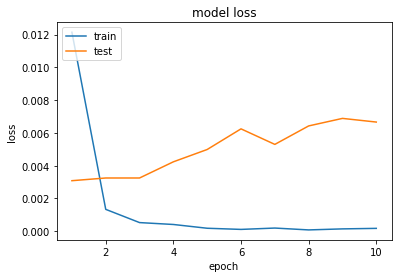

In [0]:
epochs = range(1, len(history.history['auc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
RANDOM_SEED = 123

## for train data
# index
train_nsm_idx=list(train[train['smishing']==0].index)
train_sm_idx=list(train[train['smishing']==1].index)
# 3. Mixed Sampling
random.seed(RANDOM_SEED)
train_nsm_idx = random.sample(train_nsm_idx, k=18703*5)
random.seed(RANDOM_SEED)
train_sm_idx = random.choices(train_sm_idx, k=18703*5)
# index shuffle
train_idx = train_nsm_idx + train_sm_idx
print(train_idx[:5])
random.shuffle(train_idx)
print(train_idx[:5])
# Merge
train_X = pd.DataFrame(train['text'], columns=['text']).iloc[train_idx].reset_index(drop=True)
train_y = pd.DataFrame(train['smishing'], columns=['smishing']).iloc[train_idx].reset_index(drop=True)
print(train_X.shape, train_y.shape)
## for test data
test['smishing'] = 2 # train data와 동일한 형태 생성을 위해 임의의 숫자를 추가 #이후 스미싱 여부 확률 값으로 덮어 씌워짐
test_X = pd.DataFrame(test['text'])
test_y = pd.DataFrame(test['smishing'])
print(test_X.shape, test_y.shape)

[29141, 145093, 47704, 223506, 144488]
[92222, 14474, 276657, 93742, 285727]
(187030, 1) (187030, 1)
(1626, 1) (1626, 1)


In [0]:
train_X_txt = tokenizing(train_X.text)
test_X_txt = tokenizing(test_X.text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X_txt)  
train_X_seq = tokenizer.texts_to_sequences(train_X_txt) 
vocab_size = len(tokenizer.word_index) + 1
print('vocab size: ', vocab_size)
max_len = 1000 
X_train = pad_sequences(train_X_seq, maxlen=max_len)
print("train data shape: ", X_train.shape)
test_X_seq = tokenizer.texts_to_sequences(test_X_txt) 
X_test = pad_sequences(test_X_seq, maxlen=max_len)
print("test data shape: ", X_test.shape)

vocab size:  26672
train data shape:  (187030, 1000)
test data shape:  (1626, 1000)


In [0]:
model= Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=[auc])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 128)         3414016   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 3,521,153
Traina

In [0]:
mname='BiLSTM_v6_ep3_'+format(time.time(),'.0f')

history = model.fit(X_train, train_y, epochs=5, batch_size=128, validation_split=0.3)
model_json = model.to_json()
with open(path+'model/'+mname+'.json', 'w') as json_file : 
    json_file.write(model_json)
model.save_weights(path+'model/'+mname+'.h5')

# 여기서 submission
y_pred = model.predict(X_test, batch_size=128)
submission['smishing'] = y_pred
submission.to_csv(path+'submission/'+mname+'.csv',index=False)

Train on 130920 samples, validate on 56110 samples
Epoch 1/5
130920/130920 [==============================] - 4549s 35ms/sample - loss: 0.0137 - auc: 0.9996 - val_loss: 0.0014 - val_auc: 1.0000
Epoch 2/5
130920/130920 [==============================] - 4528s 35ms/sample - loss: 0.0016 - auc: 1.0000 - val_loss: 0.0010 - val_auc: 1.0000
Epoch 3/5
130920/130920 [==============================] - 4434s 34ms/sample - loss: 7.2616e-04 - auc: 1.0000 - val_loss: 0.0023 - val_auc: 1.0000
Epoch 4/5
 78080/130920 [================>.............] - ETA: 27:13 - loss: 5.5418e-04 - auc: 1.0000